In [2]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None) # displaying all columns
merged_df = pd.read_csv('../../data/merged_df.csv', low_memory=False) # loading the merged dataframe

In [13]:
merged_df["DateOfCall"] = pd.to_datetime(merged_df["DateOfCall"]) # turn data type into datetime
merged_df["month"] = merged_df["DateOfCall"].dt.month # create column month

# creating new dataframe 
time = pd.DataFrame({'Time': merged_df.DateOfCall,
                     'AttendanceTime': merged_df.AttendanceTimeSeconds,
                     'year': merged_df.CalYear})

time = time[time.year < 2022] # keep all years before 2022
time.drop('year', axis=1, inplace=True) # drop the year column

# group the data by month and keeping mean
month = time.groupby(pd.Grouper(freq="M", key='Time')).mean() 
month.to_csv("../../data/month.csv") # save this dataframe as csv


In [12]:
print(month)

            AttendanceTime
Time                      
2009-01-31      351.794074
2009-02-28      357.192113
2009-03-31      344.103258
2009-04-30      339.052067
2009-05-31      344.258370
...                    ...
2021-08-31      345.938998
2021-09-30      354.338840
2021-10-31      353.868653
2021-11-30      353.449013
2021-12-31      357.125443

[156 rows x 1 columns]


C:\Users\User1\AppData\Local\Temp\ipykernel_15544\795053585.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv("../../data/month.csv", header=0, index_col=0, parse_dates=['Time'], squeeze=True)


Time
2009-01-31    351.794074
2009-02-28    357.192113
2009-03-31    344.103258
2009-04-30    339.052067
2009-05-31    344.258370
Name: AttendanceTime, dtype: float64

The type of this file is <class 'pandas.core.series.Series'>


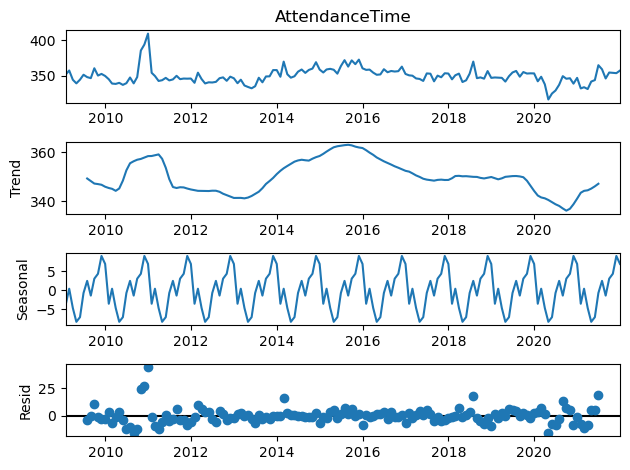

In [14]:
# read file as time series
series = pd.read_csv("../../data/month.csv", header=0, index_col=0, parse_dates=['Time'], squeeze=True)
display(series.head())
print(f'The type of this file is {type(series)}')

from statsmodels.tsa.seasonal import seasonal_decompose
new = seasonal_decompose(series)
new.plot();

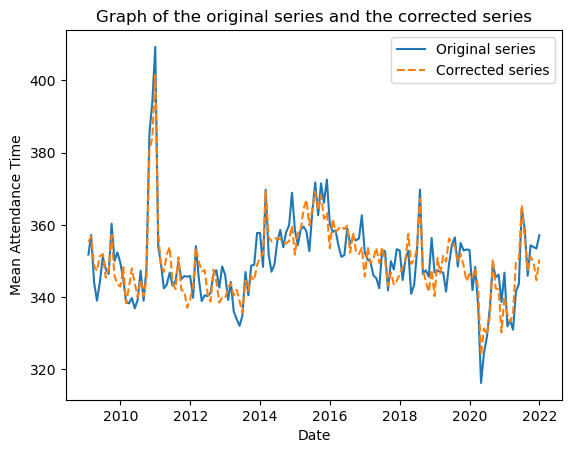

In [15]:
timelog = np.log(series)
mult = seasonal_decompose(timelog) # Here we use the transform in log we are therefore in an additive model
cvs=timelog- mult.seasonal # Seasonal coefficients are subtracted from the airpasslog series
x_cvs=np.exp(cvs) # We go to the exponential to find the original series


# We display the series

plt.plot(series, label='Original series')
plt.plot(x_cvs, '--', label='Corrected series') 
plt.title('Graph of the original series and the corrected series')
plt.xlabel('Date')
plt.ylabel('Mean Attendance Time')
plt.legend();


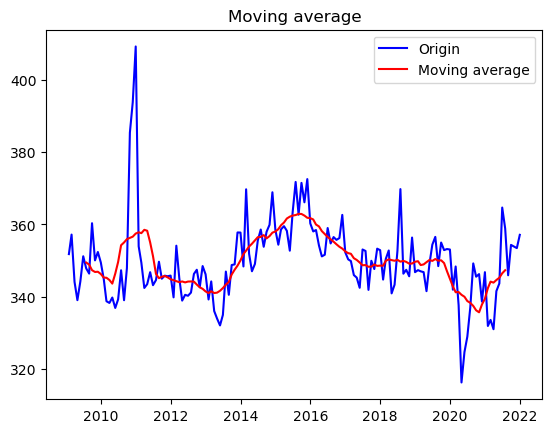

In [16]:
time_ma = timelog.rolling(12, center=True).mean()

plt.plot(np.exp(timelog), color = 'blue', label = 'Origin')
plt.plot(np.exp(time_ma), color = 'red', label = 'Moving average')
plt.legend()
plt.title('Moving average')
plt.show();

In [17]:
time_without_ma = timelog - time_ma
time_without_ma.dropna(inplace=True)

df = time_without_ma.to_frame()
df['month'] = df.index.month

seasonality = df.groupby(by='month').mean()
print(seasonality)
print(seasonality.shape)

seasonality = seasonality - seasonality.mean()


       AttendanceTime
month                
1           -0.009926
2            0.001144
3           -0.013397
4           -0.023985
5           -0.020308
6           -0.002136
7            0.008690
8           -0.004106
9            0.008612
10           0.012129
11           0.024975
12           0.018993
(12, 1)


p_value: 2.38878628185783e-06


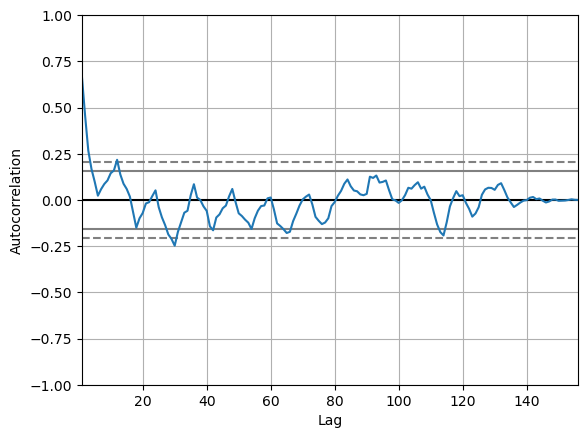

In [18]:
from statsmodels.tsa.stattools import adfuller

pd.plotting.autocorrelation_plot(timelog);
print('p_value:', adfuller(timelog)[1])

C:\Users\User1\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


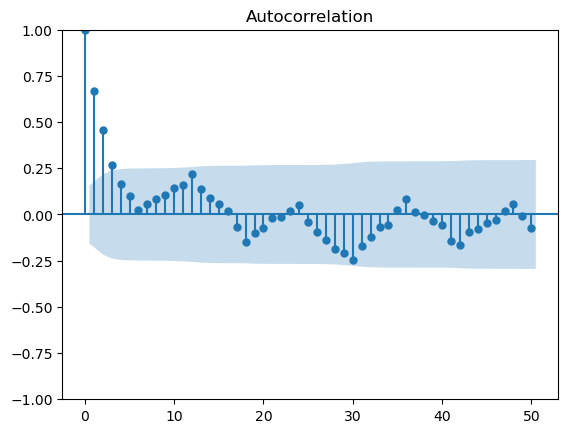

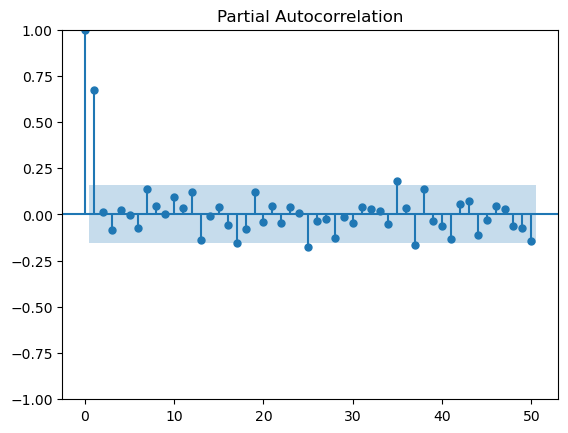

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(timelog, lags=50)
plot_pacf(timelog, lags=50);

In [21]:
from pmdarima.arima import auto_arima

model_autoarima = auto_arima(month['AttendanceTime'], seasonal=True,m=12)
print(model_autoarima)

C:\Users\User1\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,2)(1,0,1)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\User1\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\User1\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\User1\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\User1\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "C:\Users\User1\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 704, in fit
    mlefit = super(MLEModel, self).fit(start_params, method=method,
  File "C:\U

 ARIMA(1,0,0)(1,0,0)[12] intercept


In [23]:
month.shape

(156, 1)

In [24]:
import statsmodels.api as sm

sarimax = sm.tsa.SARIMAX(timelog, order=(1,0,0), seasonal_order=(1,0,0,12))
sarimax_fitted = sarimax.fit()

print(sarimax_fitted.summary())

C:\Users\User1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\User1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\User1\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                                     SARIMAX Results                                      
Dep. Variable:                     AttendanceTime   No. Observations:                  156
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 280.125
Date:                            Wed, 26 Jul 2023   AIC                           -554.250
Time:                                    20:37:41   BIC                           -545.100
Sample:                                01-31-2009   HQIC                          -550.533
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7602      0.032     23.965      0.000       0.698       0.822
ar.S.L12       0.9999   6.14e-05   

C:\Users\User1\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


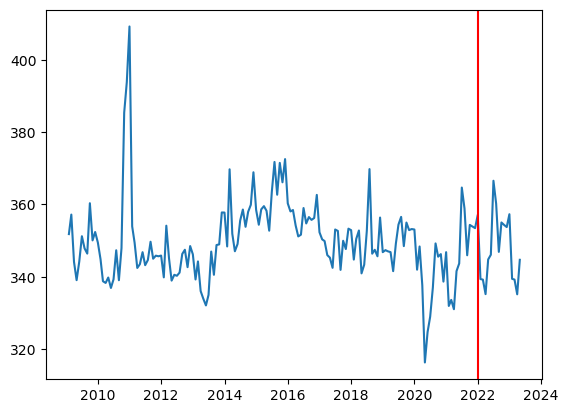

In [25]:
import datetime

pred = np.exp(sarimax_fitted.predict(156, 171))#Exponential transform and forecast
timepred = pd.concat([series, pred])#Concatenating prediction to the original series

timepred.head()
plt.plot(timepred) #Plot
plt.axvline(x= datetime.date(2022,1,1), color='red'); # Drawing a vertical line before forecasting

In [26]:
time = pd.DataFrame({'Time': merged_df.DateOfCall,
                     'AttendanceTime': merged_df.AttendanceTimeSeconds,
                     'year': merged_df.CalYear})




time['DateOfCall'] = pd.to_datetime(merged_df['DateOfCall']) # turn DateOfCall column into datetime 

real = time.groupby(pd.Grouper(freq="M", key='DateOfCall')).mean()
real.drop(real[real.year < 2022].index, inplace=True)
real.drop('year', axis=1, inplace=True)
real.head()

C:\Users\User1\AppData\Local\Temp\ipykernel_15544\605512648.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  real = time.groupby(pd.Grouper(freq="M", key='DateOfCall')).mean()


,AttendanceTime
DateOfCall,
2022-01-31,339.231785
2022-02-28,349.539788
2022-03-31,355.720531
2022-04-30,352.425040
2022-05-31,352.127840


mse: 125.75 seconds.
mae: 9.73 seconds.


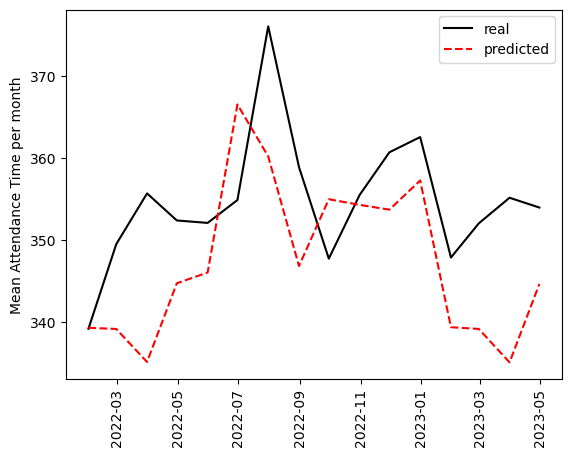

In [27]:
plt.plot(real, color='black',label='real')
plt.plot(pred, 'r--',label='predicted')
plt.xticks(rotation=90)
plt.ylabel('Mean Attendance Time per month')
plt.legend();

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print(f'mse: {round(mean_squared_error(real, pred), 2)} seconds.')
print(f'mae: {round(mean_absolute_error(real, pred), 2)} seconds.')